# MNIST handwritten digits classification with regularized MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**.

The neural network will be regularized with


1.   Dropout
2.   Batchnormalization





First, the needed imports. 

In [9]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
#import seaborn as sns
#sns.set()

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.4.0  Device: cuda


## Data

Next we'll load the MNIST data.  First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation*, instead of for testing the final model.

In [10]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [11]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

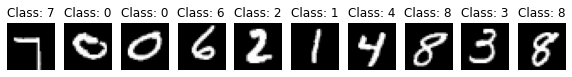

In [12]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+str(y_train[i].item()))

## MLP network definition

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients.  We select *stochastic gradient descent (with momentum)* as the optimization algorithm, and set *learning rate* to 0.01.  Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

#### Question: Complete the missing blocks in the definition of the  convNet architecture 

The neural network should be composed as (FullyConnected 256 -> ReLU -> Fully Connected 256 -> ReLU -> Fully Connected 10 -> softmax)

In [13]:
H1 = 256
H2 = 256 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # To complete
        self.fc1 = nn.Linear(28*28, H1)
        self.fc2 = nn.Linear(H1, H2)
        self.fc3 = nn.Linear(H2, 10)
                
    def forward(self, x):
        # To complete
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)

        return x

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


### Question: Complete the missing blocks in the definition of the "DropoutNet" architecture

The neural network should be composed as (FullyConnected 256 -> ReLU -> Dropout (0.2) -> Fully Connected 256 -> ReLU -> Dropout (0.5) -> Fully Connected 10 -> softmax)

In [14]:
class NetDrop(nn.Module):
    def __init__(self):
        super(NetDrop, self).__init__()
        # To complete

        self.fc1 = nn.Linear(28*28, H1)
        self.dp1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(H1, H2)
        self.dp2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(H2, 10)


    def forward(self, x):
        # To complete
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.dp1(x)
        x = F.relu(self.fc2(x))
        x = self.dp2(x)
        x = F.log_softmax(self.fc3(x),dim=1)
        return  x # To complete

modelDrop = NetDrop().to(device)
optimizerDrop = torch.optim.SGD(modelDrop.parameters(), lr=0.01, momentum=0.)

print(modelDrop)

NetDrop(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (dp1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (dp2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


### Question: Complete the missing blocks in the definition of the  "Batchnormalization" architecture

The neural network should be composed as (FullyConnected 256 -> ReLU -> Batchnorm -> Fully Connected 256 -> ReLU -> Batchnorm -> Fully Connected 10 -> softmax)

In [15]:
class NetBatchNorm(nn.Module):
    def __init__(self):
        super(NetBatchNorm, self).__init__()
        # To complete
        self.fc1 = nn.Linear(28*28, H1)
        self.bn1 = nn.BatchNorm1d(H1)
        self.fc2 = nn.Linear(H1, H2)
        self.bn2 = nn.BatchNorm1d(H2)
        self.fc3 = nn.Linear(H2, 10)

    def forward(self, x):
        # To complete
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = F.log_softmax(self.fc3(x),dim=1)
        return x# To complete

modelBatchNorm = NetBatchNorm().to(device)
optimizerBatchNorm = torch.optim.SGD(modelBatchNorm.parameters(), lr=0.01, momentum=0.)

print(modelBatchNorm)

NetBatchNorm(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


## Learning

Let's now define functions to `train()` and `test()` the model. 

In [0]:
def train(model, optimizer, epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [0]:
def validate(model, loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `test()`. 

Training without Dropout

In [18]:
%%time
epochs = 3

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch)
    validate(model, lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.284146
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.210761
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.988475
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.346035
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.932998
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.485248
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.370535
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.513165
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.537996
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.341967

Validation set: Average loss: 0.4061, Accuracy: 8871/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.474515
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.812244
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.437089
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.272379
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.253858
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.458769
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.385385
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.405153
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.20

Training with Dropout

In [19]:
%%time

lossvDrop, accvDrop = [], []
for epoch in range(1, epochs + 1):
    train(modelDrop, optimizerDrop, epoch)
    validate(modelDrop, lossvDrop, accvDrop)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.287098
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.208879
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.007894
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.308116
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.122079
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.933245
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.787024
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.918901
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.717536
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.622069

Validation set: Average loss: 0.4599, Accuracy: 8738/10000 (87%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.484029
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.645562
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.726571
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.612781
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.550043
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.669646
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.258005
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.273352
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.46

Training with Batchnormalization

In [20]:
%%time

lossvBN, accvBN = [], []
for epoch in range(1, epochs + 1):
    train(modelBatchNorm, optimizerBatchNorm, epoch)
    validate(modelBatchNorm, lossvBN, accvBN)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300468
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.350177
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.385787
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.275286
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.188213
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.098011
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.390403
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.132832
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.071553
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.281846

Validation set: Average loss: 0.1242, Accuracy: 9645/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.048242
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.046468
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.142319
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.046512
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.067410
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.012859
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.301374
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.134520
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.03

Let's now visualize how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

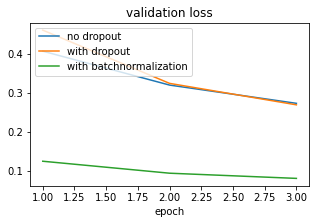

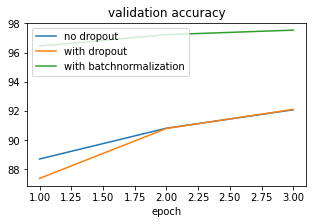

In [21]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv, label='no dropout')
plt.plot(np.arange(1,epochs+1), lossvDrop, label='with dropout')
plt.plot(np.arange(1,epochs+1), lossvBN, label='with batchnormalization')
plt.legend(loc='upper left');
plt.xlabel('epoch')
plt.title('validation loss')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv, label='no dropout')
plt.plot(np.arange(1,epochs+1), accvDrop, label='with dropout')
plt.plot(np.arange(1,epochs+1), accvBN, label='with batchnormalization')
plt.legend(loc='upper left');
plt.xlabel('epoch')
plt.title('validation accuracy');

### Question (model tuning): compare the gain when the first layer has less neurons (50 instead of 256)

**Answer:**

It seems that if we have 50 neurons in the hidden layers we still have a good result, especially using batch normalization that we kept the same accuracy.


In [22]:
H1 = 50
H2 = 50

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # To complete
        self.fc1 = nn.Linear(28*28, H1)
        self.fc2 = nn.Linear(H1, H2)
        self.fc3 = nn.Linear(H2, 10)
                
    def forward(self, x):
        # To complete
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)

        return x

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


Training without dropout

In [23]:
%%time
epochs = 3

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch)
    validate(model, lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.283574
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.266637
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.161770
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.806515
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.283439
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.983176
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.700347
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.632986
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.386514
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.492953

Validation set: Average loss: 0.4549, Accuracy: 8755/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.493719
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.427150
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.501196
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.208001
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.257262
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.384105
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.204651
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.221024
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.21

Training with dropout

In [24]:
%%time

lossvDrop, accvDrop = [], []
for epoch in range(1, epochs + 1):
    train(modelDrop, optimizerDrop, epoch)
    validate(modelDrop, lossvDrop, accvDrop)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.668243
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.665797
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.197865
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.169687
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.178556
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.379997
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.198834
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.304628
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.118316
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.632494

Validation set: Average loss: 0.2287, Accuracy: 9327/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.420296
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.145339
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.172910
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.436713
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.285901
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.397371
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.353827
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.435137
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.23

Training with batch normalization

In [25]:
%%time

lossvBN, accvBN = [], []
for epoch in range(1, epochs + 1):
    train(modelBatchNorm, optimizerBatchNorm, epoch)
    validate(modelBatchNorm, lossvBN, accvBN)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.171337
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.087335
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.035765
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.023363
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.380381
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.086931
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.037303
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.063043
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.040657
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.044988

Validation set: Average loss: 0.0739, Accuracy: 9778/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.036398
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.143514
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.081000
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.064783
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.054721
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.016513
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.013145
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.025301
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.10

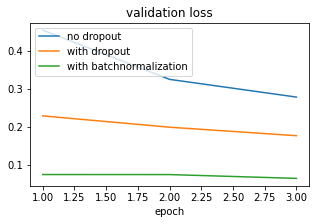

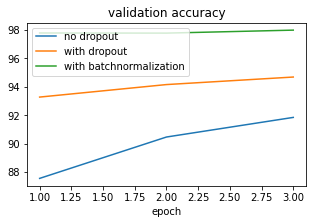

In [26]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv, label='no dropout')
plt.plot(np.arange(1,epochs+1), lossvDrop, label='with dropout')
plt.plot(np.arange(1,epochs+1), lossvBN, label='with batchnormalization')
plt.legend(loc='upper left');
plt.xlabel('epoch')
plt.title('validation loss')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv, label='no dropout')
plt.plot(np.arange(1,epochs+1), accvDrop, label='with dropout')
plt.plot(np.arange(1,epochs+1), accvBN, label='with batchnormalization')
plt.legend(loc='upper left');
plt.xlabel('epoch')
plt.title('validation accuracy');

### Question (model tuning): increase the number of epochs for the training (10 instead of 3)

In [27]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch)
    validate(model, lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.533468
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.262451
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.250248
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.124032
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.553450
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.420737
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.189371
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.316960
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.254160
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.199123

Validation set: Average loss: 0.2547, Accuracy: 9285/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.253424
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.135862
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.210848
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.643015
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.455499
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.164481
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.109748
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.484800
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.08

In [28]:
%%time

lossvDrop, accvDrop = [], []
for epoch in range(1, epochs + 1):
    train(modelDrop, optimizerDrop, epoch)
    validate(modelDrop, lossvDrop, accvDrop)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.175830
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.440752
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.421567
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.137551
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.189649
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.182242
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.103740
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.085681
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.212867
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.375766

Validation set: Average loss: 0.1620, Accuracy: 9502/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.099807
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.054455
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.171602
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.204868
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.151723
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.109239
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.154648
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.038348
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.09

In [29]:
%%time

lossvBN, accvBN = [], []
for epoch in range(1, epochs + 1):
    train(modelBatchNorm, optimizerBatchNorm, epoch)
    validate(modelBatchNorm, lossvBN, accvBN)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.070607
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.005392
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.032110
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.018163
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.010969
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.018565
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.025043
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.022020
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.126408
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.068242

Validation set: Average loss: 0.0664, Accuracy: 9786/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.009179
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.157844
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.003591
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.003342
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.016747
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.022635
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.015810
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.029343
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.05

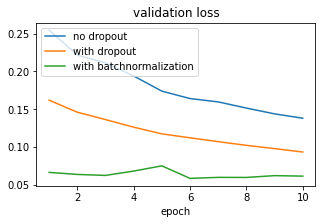

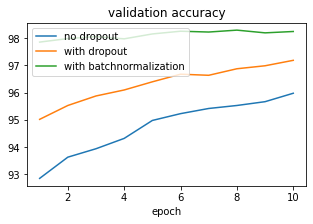

In [30]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv, label='no dropout')
plt.plot(np.arange(1,epochs+1), lossvDrop, label='with dropout')
plt.plot(np.arange(1,epochs+1), lossvBN, label='with batchnormalization')
plt.legend(loc='upper left');
plt.xlabel('epoch')
plt.title('validation loss')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv, label='no dropout')
plt.plot(np.arange(1,epochs+1), accvDrop, label='with dropout')
plt.plot(np.arange(1,epochs+1), accvBN, label='with batchnormalization')
plt.legend(loc='upper left');
plt.xlabel('epoch')
plt.title('validation accuracy');

### Question: Try a model using convolution layer

In [31]:
D_in = 28*28 # images with 28*28
D_out = 10 # 10 classes
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 3, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.linear1 = nn.Linear(12*12*3, 12) 
        self.linear2 = nn.Linear(12, D_out)
        
    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 12 * 12 * 3)
        x = self.linear1(x)
        x = F.relu(x)
        x = F.log_softmax(self.linear2(x),dim=1)
        return x

cnn_model = ConvNet().to(device)
optimizer_cnn = torch.optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.)
criterion = nn.CrossEntropyLoss()

print(cnn_model)

ConvNet(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=432, out_features=12, bias=True)
  (linear2): Linear(in_features=12, out_features=10, bias=True)
)


In [32]:
  for epoch in range(1, epochs + 1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer_cnn.zero_grad()

        # forward + backward + optimize
        outputs = cnn_model(inputs)                 # calculate y
        loss = criterion(outputs, labels)     # calculate the loss
        loss.backward()                       # update the gradient
        optimizer_cnn.step()                      # SGD to find the optimal parameters
        
print('Finished Training')

Finished Training


In [33]:
val_loss, correct = 0, 0
loss_vector_cnn, accuracy_vector_cnn = [], []
for data, target in validation_loader:
    data = data.to(device)
    target = target.to(device)
    output = cnn_model(data)
    val_loss += criterion(output, target).data.item()
    pred = output.data.max(1)[1] # get the index of the max log-probability
    correct += pred.eq(target.data).cpu().sum()

val_loss /= len(validation_loader)
loss_vector_cnn.append(val_loss)

accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
accuracy_vector_cnn.append(accuracy)
    
print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    val_loss, correct, len(validation_loader.dataset), accuracy))



Validation set: Average loss: 0.1274, Accuracy: 9624/10000 (96%)



In [38]:
for parameter in cnn_model.parameters():
    print(parameter.size())

torch.Size([3, 1, 5, 5])
torch.Size([3])
torch.Size([12, 432])
torch.Size([12])
torch.Size([10, 12])
torch.Size([10])


In [39]:
for parameter in model.parameters():
    print(parameter.size())

torch.Size([50, 784])
torch.Size([50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


**Remark:** Using a CNN we lost 2 points in accuracym but reduced the computations, as we can see we have less parameters.